In [24]:
%matplotlib inline
import os
import vision
from docopt import docopt
from torchvision import transforms
from glow.builder import build
from glow.trainer import Trainer
from glow.config import JsonConfig
import cv2
import random
import torch
import numpy as np
from matplotlib import pyplot as plt

# functions

In [25]:
def run_z(graph, z):
    graph.eval()
    x = graph(z=torch.tensor([z]).cuda(), eps_std=0.3, reverse=True)
    img = x[0].permute(1, 2, 0).detach().cpu().numpy()
    img = img[:, :, ::-1]
    img = cv2.resize(img, (256, 256))
    return img

# load data

In [26]:
hparams = JsonConfig("hparams/celeba1.json")
dataset = vision.Datasets["celeba"]
dataset_root = './dataset/CelebA'
# set transform of dataset
transform = transforms.Compose([
transforms.CenterCrop(hparams.Data.center_crop),
        transforms.Resize(hparams.Data.resize),
        transforms.ToTensor()])
# build
graph = build(hparams, False)["graph"]
dataset = dataset(dataset_root, transform=transform)

[Builder]: Found 1 gpu
[Builder]: cuda:1 is not found, ignore.
[Builder]: cuda:2 is not found, ignore.
[Builder]: cuda:3 is not found, ignore.
[Checkpoint]: Load ./results/celeba/trained.pkg successfully
[Builder]: Use cuda [0] to train, use 0 to load data and get loss.
Begin to parse all image attrs
Find 202599 images, with 40 attrs


In [27]:
# get Z
z_dir = './celeba_z'
if not os.path.exists(z_dir):
    print("Generate Z to {}".format(z_dir))
    os.makedirs(z_dir)
    generate_z = True
    delta_Z = graph.generate_attr_deltaz(dataset)
    for i, z in enumerate(delta_Z):
        np.save(os.path.join(z_dir, "detla_z_{}.npy".format(i)), z)
    print("Finish generating")
else:
    print("Load Z from {}".format(z_dir))
    generate_z = False
    # try to load
    try:
        delta_Z = []
        for i in range(hparams.Glow.y_classes):
            z = np.load(os.path.join(z_dir, "detla_z_{}.npy".format(i)))
            delta_Z.append(z)
    except FileNotFoundError:
        # need to generate
        generate_z = True
        print("Failed to load {} Z".format(hparams.Glow.y_classes))
        quit()   

Load Z from ./celeba_z


In [64]:
print("No. of images to choose from:", len(dataset))
print("No. of attributes to choose from:", len(delta_Z))
index_set = list(range(len(dataset.attrs)))
print("Attribute list:")
for i in range(len(delta_Z)): print('{},{}'.format(index_set[i],dataset.attrs[i]))

No. of images to choose from: 202599
No. of attributes to choose from: 40
Attribute list:
0,5_o_Clock_Shadow
1,Arched_Eyebrows
2,Attractive
3,Bags_Under_Eyes
4,Bald
5,Bangs
6,Big_Lips
7,Big_Nose
8,Black_Hair
9,Blond_Hair
10,Blurry
11,Brown_Hair
12,Bushy_Eyebrows
13,Chubby
14,Double_Chin
15,Eyeglasses
16,Goatee
17,Gray_Hair
18,Heavy_Makeup
19,High_Cheekbones
20,Male
21,Mouth_Slightly_Open
22,Mustache
23,Narrow_Eyes
24,No_Beard
25,Oval_Face
26,Pale_Skin
27,Pointy_Nose
28,Receding_Hairline
29,Rosy_Cheeks
30,Sideburns
31,Smiling
32,Straight_Hair
33,Wavy_Hair
34,Wearing_Earrings
35,Wearing_Hat
36,Wearing_Lipstick
37,Wearing_Necklace
38,Wearing_Necktie
39,Young


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


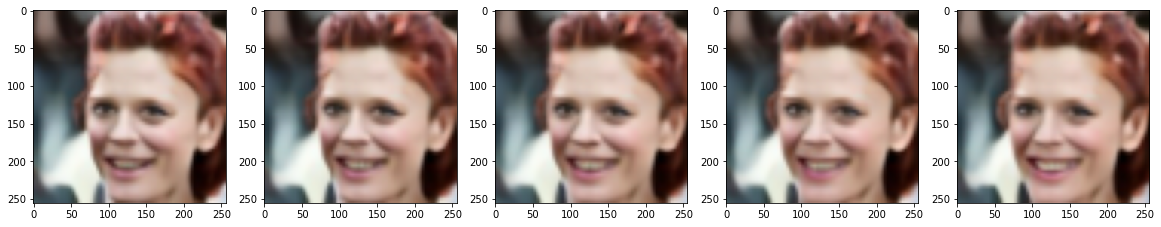

In [81]:
base_index = 1
attr_index = 31
attr_name = dataset.attrs[attr_index]
z_delta = delta_Z[attr_index]

graph.eval()
z_base = graph.generate_z(dataset[base_index]["x"])
# begin to generate new image
images = []
names = []
images.append(run_z(graph, z_base))
names.append("reconstruct_origin")
interpolate_n = 5
fig, ax = plt.subplots(1,interpolate_n, figsize=(20,20))
for i in range(0, interpolate_n+1):
    #manipulate z
    d = -z_delta * float(i) / float(interpolate_n)
    images.append(run_z(graph, z_base + d))
    names.append("attr_{}_{}".format(attr_name, interpolate_n + i))
    if i > 0:
        new_image = run_z(graph, z_base - d)
        images.append(new_image)
        names.append("attr_{}_{}".format(attr_name, interpolate_n - i))
        ax[i-1].imshow(new_image[..., [2,1,0]]) #bgr to rgb